__BIOBSS - ACC Pipeline__

_This notebook includes guidelines to help using pipeline module for ACC signal processing and feature extraction._

In [1]:
#Import BIOBSS and other required packages

#import biobss
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import biobss from local to run without installing
import sys
sys.path.append("../")
import biobss

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1. [ACC Sample Data](#sampledata)<br>
2. [Create Pipeline Object](#create_pipeline)<br>
3. [Set Pipeline Inputs](#set_input)<br>
4. [Create Bio Process Objects](#create_bioprocess)<br>
5. [Add Bio Process Objects to Pipeline](#add_bioprocess)<br>
6. [Run Preprocessing Pipeline](#run_pipeline)<br>
7. [Create Feature Objects](#create_feature)<br>
8. [Add Feature Objects to Pipeline](#add_feature)
9. [Extract Features](#extract_features)<br>

### __ACC Sample Data__
<a id="sampledata"></a>

ACC sample data is provided as a csv file in BIOBSS\sample data. The data file contains 3-axis ACC signals of 5-minutes length, sampled at 32 Hz. 

In [2]:
#Load the sample data
data, info = biobss.utils.load_sample_data(data_type='ACC')
accx = np.asarray(data['ACCx'])
accy = np.asarray(data['ACCy'])
accz = np.asarray(data['ACCz'])
fs = info['sampling_rate']
L = info['signal_length']

ACC signals can be plotted using BIOBSS's plotting functions.

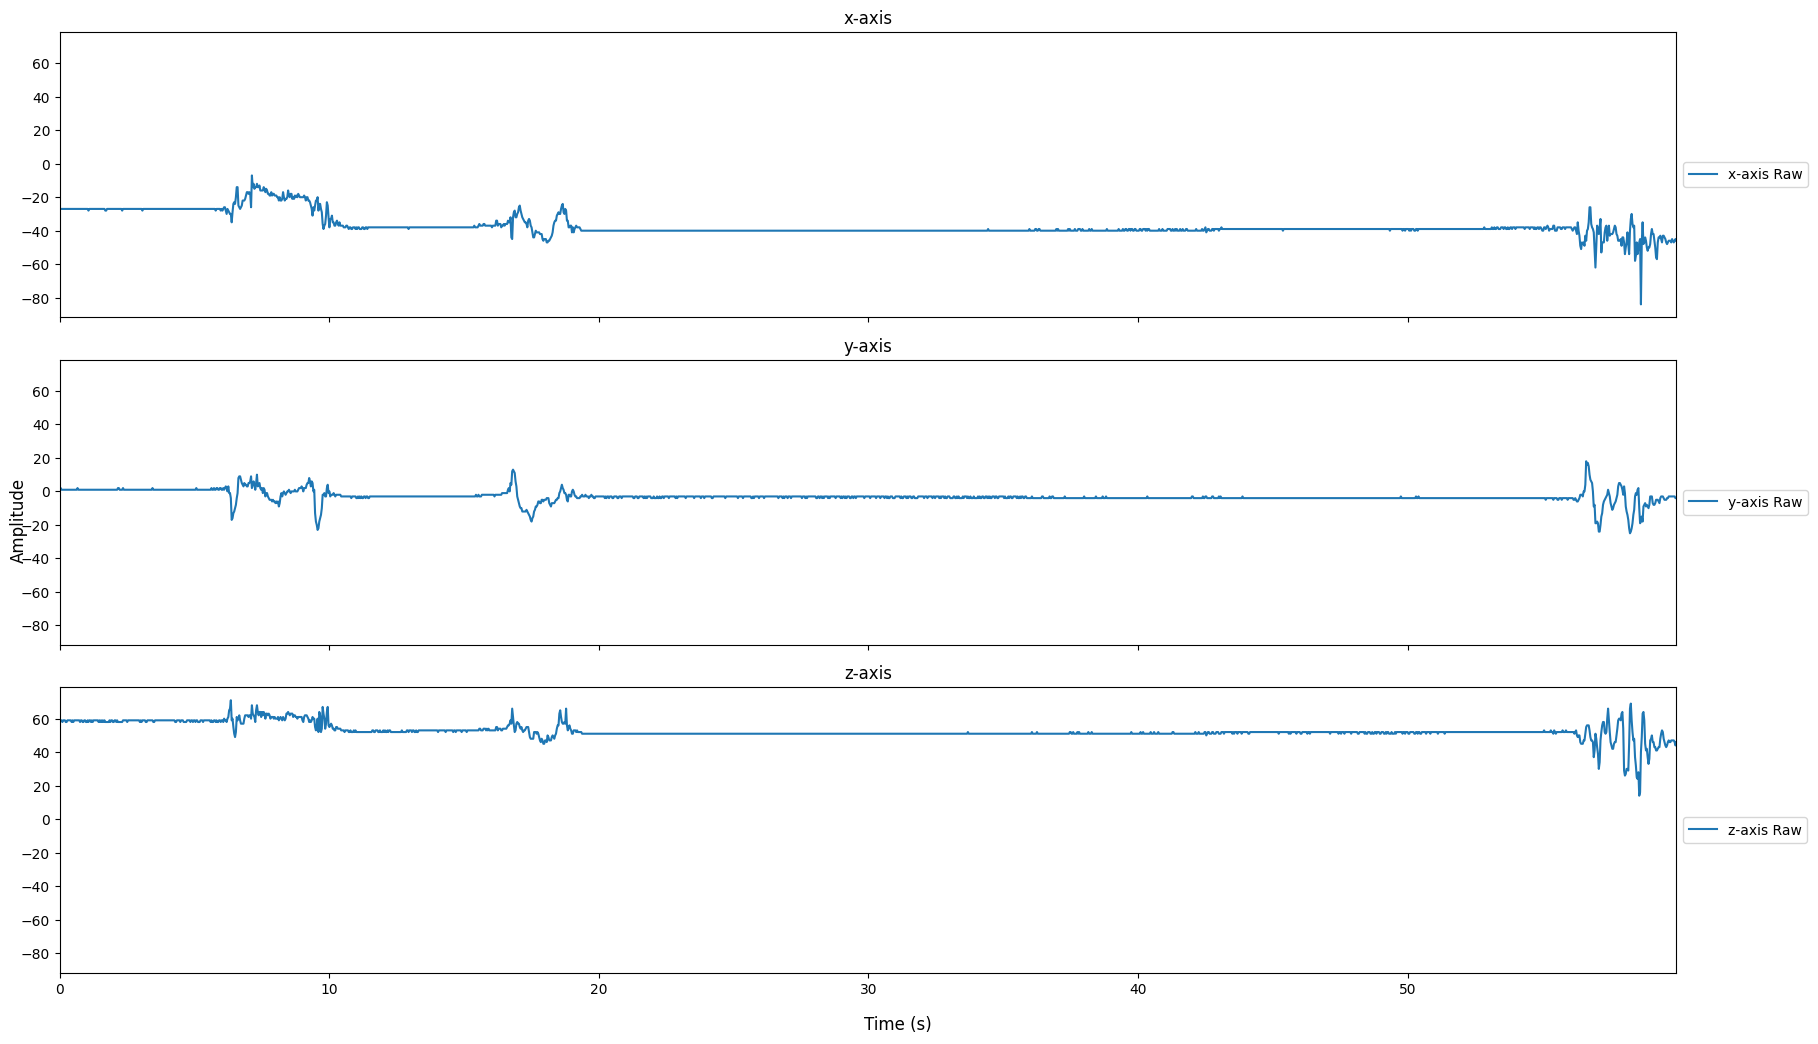

In [3]:
#Generate inputs as dictionaries
signals = {'x-axis':{'Raw': accx}, 'y-axis':{'Raw': accy}, 'z-axis':{'Raw': accz}}
biobss.imutools.plot_acc(signals=signals, sampling_rate=fs, method='matplotlib', show_peaks=False)

### __Create Pipeline Object__
<a id="create_pipeline"></a>

First, a pipeline object should be created.

In [4]:
pipeline = biobss.pipeline.Bio_Pipeline()   # Create a pipeline object

For windowed processing, __windowed_process__ should be set as __True__. Additionally, __window_size__ and __step_size __ should be defined. As an example, window_size=10 means that the pipeline will process 10 seconds of data at a time and step_size=5 means signal will be shifted by 5 seconds for each window (overlapped region).

In [5]:
pipeline_windowed = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=10,step_size=5)  # Create a pipeline object

### __Set Pipeline Inputs__
<a id="set_input"></a>

Pipeline input can be set using the __set_input__ method. 

In [5]:
# Set the input signal and sampling rate
pipeline.set_input(data=accx, sampling_rate=fs, name='ACCx_Raw')
pipeline.input.add_channel(signal=accy, sampling_rate=fs, channel_name='ACCy_Raw')
pipeline.input.add_channel(signal=accz, sampling_rate=fs, channel_name='ACCz_Raw')


### __Create Bio Process Objects__
<a id="create_bioprocess"></a>

Any process can be added to the pipeline by passing the method to a Bio_Process constructor. The Bio_Process constructor takes the following arguments:

- process_method: The method to be added to the pipeline
- process_name: Name of the method to be added to the pipeline
- **kwargs: Keyword arguments to be passed to the process method

Pipeline processes the given input sequentially. The input is passed from one process to the next.

For ACC signal, the processing given below is added to the pipeline:

 1. Filtering signals
    * Signal can be filtered with defining filters
      * <code> biobss.preprocess.filter_signal(sig,sampling_rate=fs,filter_type='lowpass',N=2,f_upper=5) </code>
    * Siganls can be filtered with predefined filters
      * <code> biobss.preprocess.filter_signal(sig, sampling_rate=fs, signal_type='ACC', method='lowpass') </code>
 2. Peak Detection

In [6]:
filter_acc = biobss.pipeline.Bio_Process(process_method=biobss.imutools.filter_acc,process_name="Filter ACC")
find_peaks = biobss.pipeline.Bio_Process(biobss.preprocess.peak_detection,process_name='Find ACC Peaks',
                                         method='peakdet', delta=0.01, correct_peaks=True)

#### __Add Bio Process Objects to Pipeline__
<a id="add_bioprocess"></a>

In [7]:
# Pipeline steps are added to the pipeline sequentially, the order of the steps is important as the output of one step is the input of the next step
# These steps will be processed in the order they are added to the pipeline
pipeline.process_queue.add_process(filter_acc,input_signals=['ACCx_Raw'],output_signals=['ACCx_Filtered'], sampling_rate=fs)
pipeline.process_queue.add_process(filter_acc,input_signals=['ACCy_Raw'],output_signals=['ACCy_Filtered'], sampling_rate=fs)
pipeline.process_queue.add_process(filter_acc,input_signals=['ACCz_Raw'],output_signals=['ACCz_Filtered'], sampling_rate=fs)

pipeline.process_queue.add_process(find_peaks,input_signals=['ACCx_Filtered'],output_signals=['ACCx_Peaks'], sampling_rate=fs, is_event=True)
pipeline.process_queue.add_process(find_peaks,input_signals=['ACCy_Filtered'],output_signals=['ACCy_Peaks'], sampling_rate=fs, is_event=True)
pipeline.process_queue.add_process(find_peaks,input_signals=['ACCz_Filtered'],output_signals=['ACCz_Peaks'], sampling_rate=fs, is_event=True)

#### __Run Pipeline__
<a id="run_pipeline"></a>

In [8]:
# Pipeline is run, this will process the input data in the pipeline
pipeline.run_pipeline()

In [9]:
pipeline.data

Signal object with 12 channel(s)
ACCx_Raw (32Hz) (1 windows) ((1920,))
ACCy_Raw (32Hz) (1 windows) ((1920,))
ACCz_Raw (32Hz) (1 windows) ((1920,))
ACCx_Filtered (32Hz) (1 windows) ((1920,))
ACCy_Filtered (32Hz) (1 windows) ((1920,))
ACCz_Filtered (32Hz) (1 windows) ((1920,))
ACCx_Peaks_Peak_locs (32Hz) (1 windows)
ACCx_Peaks_Trough_locs (32Hz) (1 windows)
ACCy_Peaks_Peak_locs (32Hz) (1 windows)
ACCy_Peaks_Trough_locs (32Hz) (1 windows)
ACCz_Peaks_Peak_locs (32Hz) (1 windows)
ACCz_Peaks_Trough_locs (32Hz) (1 windows)

In order the processed data, signals and peaks can be defined as shown below.

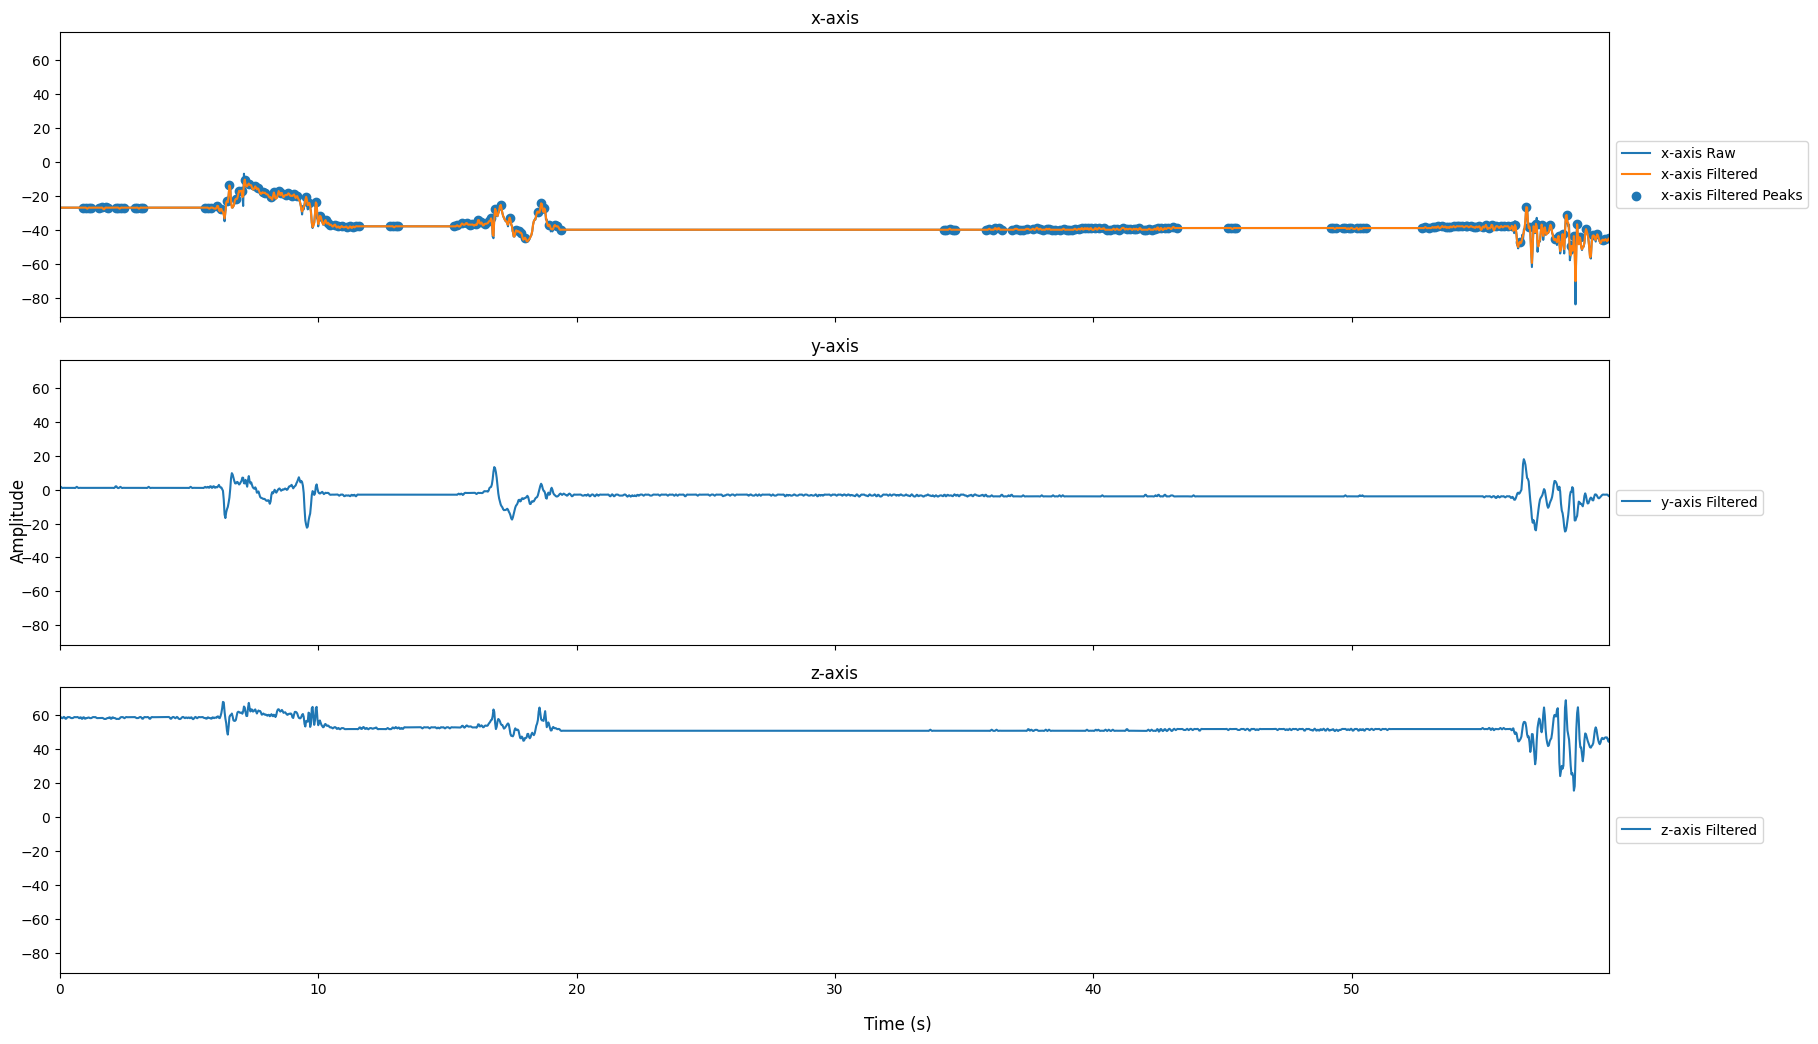

In [10]:
#Generate inputs as dictionaries
signals = {'x-axis':{'Raw': pipeline.data['ACCx_Raw'].channel, 'Filtered': pipeline.data['ACCx_Filtered'].channel}, 'y-axis':{'Filtered': pipeline.data['ACCy_Filtered'].channel}, 'z-axis':{'Filtered': pipeline.data['ACCz_Filtered'].channel}}
peaks = {'x-axis':{'Filtered':{'Peaks': pipeline.data['ACCx_Peaks_Peak_locs'].channel}}}
biobss.imutools.plot_acc(signals=signals, peaks=peaks, sampling_rate=fs, method='matplotlib', show_peaks=True)

Same steps can be applied for windowed data by replacing __pipeline__ object with __pipeline_windowed__ object in the cells above.

### __Create Feature Objects__ 
<a id="create_feature"></a>

Feature extraction steps can be added to the pipeline by passing the method to a Feature constructor. The Feature constructor takes the following arguments:

- function: The function to be used for feature extraction
- name: Name of the feature set
- **kwargs: Keyword arguments to be passed to the function

Feature extraction steps are applied simultaneously. Outputs of all feature extraction steps are merged at the end.

In [11]:
#Frequency domain features
acc_freq = biobss.pipeline.feature_extraction.Feature(function= biobss.imutools.acc_freq_features, name='ACC_Frequency')
#Statistical features
acc_time = biobss.pipeline.feature_extraction.Feature(function= biobss.imutools.acc_stat_features, name='ACC_Statistical')
#Correlation features
acc_corr = biobss.pipeline.feature_extraction.Feature(function= biobss.imutools.acc_corr_features, name='ACC_Correlation')

In [ ]:
pipeline.add_feature_step(acc_freq, input_signals=)

#### __Extract Features__
<a id="extract_features"></a>

In [ ]:
# Statistical and signal features are extracted from the EDA_Tonic, EDA_Phasic and EDA_Raw channels
# Supplied prefix is added to the feature name
pipeline.extract_features()



In [ ]:
# Represetation of the pipeline features after extraction
# Each row is a feature vector for a window
# index is the timestamp of the window (this can be selected as start, end or center of the window)
pipeline.features